# importing libraries

In [1]:
import torch
import numpy as np
import pandas as pd
import pickle

In [2]:
PICKLE_DATA_PATH = 'dnam_data_dummy.pkl'
with open(PICKLE_DATA_PATH, 'rb') as handle:
    dataset = pickle.load(handle)

In [3]:
phenotype_data = dataset['pheno']
beta_value_data = dataset['beta']
print(beta_value_data.shape)

(231, 5000)


# 231 x 5000 -- 231 samples, each sample has values for 5000 CpGs

In [4]:
beta_value_data.isnull().values.any()

True

Above cell shows we have some null/nan values in the dataset, we will impute/replace those with "realisitc values".  
Alternatively, samples with missing values can just be removed, or dealt with in other methods

In [5]:
from sklearn.impute import SimpleImputer

In [6]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
beta_value_data_imputed = imputer.fit_transform(beta_value_data)
# we are replacing the missing/null/nan values with the mean of that CpG column
# Can ignore the below red warnings

/dartfs-hpc/rc/home/8/f005g78/anaconda3/envs/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/dartfs-hpc/rc/home/8/f005g78/anaconda3/envs/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [7]:
print(np.isnan(beta_value_data_imputed).any())
print(type(beta_value_data_imputed))

False
<class 'numpy.ndarray'>


With the above cell, we now see the following:
- beta_value_data_imputed --> "clean", does not contain null/missing values anymore
- beta_value_data_imputed is now a numpy array that contains the features

# Now, we will split the data into a training and validation set -- feel free to skip this, if it does not apply

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test = train_test_split(beta_value_data_imputed,test_size=0.13,random_state=42)
print(X_train.shape)
print(X_test.shape)
# Shape --> number of samples x number of CpGs

(200, 5000)
(31, 5000)


# Creating Pytorch Datasets and Dataloaders

In [10]:
from torch.utils.data import TensorDataset, DataLoader
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)
train_dataset = TensorDataset(X_train_tensors)
test_dataset = TensorDataset(X_test_tensors)

train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Now we can create and train our VAE model

Define model

In [11]:
import torch.nn.functional as F
import torch.nn as nn
class VAE(nn.Module):
    def __init__(self,n_cpgs,n_hidden,n_hidden_2):
        super(VAE,self).__init__()
        
        self.encoder = nn.Linear(n_cpgs,n_hidden)
        self.encoder_2 = nn.Linear(n_hidden,n_hidden_2)
        # Can add additional encoder layers here
        
        self.mu = nn.Linear(n_hidden_2,n_hidden_2)
        
        self.logvar = nn.Linear(n_hidden_2,n_hidden_2)
        
        # Can add additional decoder layers here
        self.decoder = nn.Linear(n_hidden_2,n_hidden)
        self.decoder_2 = nn.Linear(n_hidden,n_cpgs)
        
    def encode(self,x):
        x = F.relu(self.encoder(x))
        x = F.relu(self.encoder_2(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu,logvar
    
    def reparam(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self,z):
        z = F.relu(self.decoder(z))
        z = torch.sigmoid(self.decoder_2(z))
        # applying sigmoid function because beta values range from 0-1, and sigmoid ensures that
        return z
    
    def forward(self,x):
        mu,logvar = self.encode(x)
        z = self.reparam(mu,logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

Define Loss

In [12]:
def vae_loss(recon_x, x, mu, logvar, beta = 1e-3):
    mse = torch.nn.functional.mse_loss(recon_x,x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse+ KLD*beta, mse

Define train/val loops

In [13]:
import copy
def train_loop(model, train_loader, optimizer, device, beta=1e-2):
    train_loss = 0
    for batch_index, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()

        reconstructed_data, mu, logvar = model(data)
        loss, mse = vae_loss(reconstructed_data, data, mu, logvar, beta)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= (len(train_loader)/train_loader.batch_size) # average loss for the epoch
    return train_loss

def eval_loop(model, val_loader, device):
    model.train(False)
    val_loss = 0
    for batch_index, data in enumerate(val_loader):
        data = data[0].to(device)
        reconstructed_data, mu, logvar = model(data)
        loss, mse = vae_loss(reconstructed_data, data, mu, logvar)
        val_loss = val_loss + loss.item()
    val_loss = val_loss / (len(val_loader)/val_loader.batch_size)
    return val_loss

def train(model,epochs,train_loader,val_loader,optimizer,device,beta):
    best_val_loss=np.inf
    best_model_dict=copy.deepcopy(model).cpu().state_dict()
    for epoch in range(epochs):
        model.train(True)
        train_loss=train_loop(model, train_loader, optimizer, device, beta)
        val_loss=eval_loop(model, val_loader, device)
        print(f'Epoch {epoch} Train Loss {train_loss}')
        print(f'Epoch {epoch} Val Loss {val_loss}')
        if val_loss<=best_val_loss:
            best_model_dict=copy.deepcopy(model).cpu().state_dict()
            best_val_loss=val_loss
    model.load_state_dict(best_model_dict)

Define test loop

In [14]:
def test_loop(model, val_loader, device):
    Z=[]
    model.train(False)
    with torch.no_grad():
        for batch_index, data in enumerate(val_loader):
            data = data[0].to(device)
            reconstructed_data, mu, logvar = model(data)
            Z.append(mu.cpu().numpy())
    return np.vstack(Z)

Train model

In [19]:
DEVICE = torch.device('cuda:0') # use 'cpu' if you'd like to use cpu instead of gpu
N_CPGS = X_train.shape[1] # shape is N_samples, N_cpgs
vae_model = VAE(N_CPGS, 512, 256).to(DEVICE)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)
train(vae_model, 20, train_loader, test_loader, optimizer, DEVICE, beta=1e-1)

Epoch 0 Train Loss 26.763242611518272
Epoch 0 Val Loss 1.1390433311462402
Epoch 1 Train Loss 4.947587398382334
Epoch 1 Val Loss 1.1039457321166992
Epoch 2 Train Loss 2.9664879395411563
Epoch 2 Val Loss 1.1149696707725525
Epoch 3 Train Loss 1.8376435408225427
Epoch 3 Val Loss 1.1022226810455322
Epoch 4 Train Loss 1.4266550082426805
Epoch 4 Val Loss 1.0898057222366333
Epoch 5 Train Loss 1.503828158745399
Epoch 5 Val Loss 1.0832374095916748
Epoch 6 Train Loss 1.4329711565604577
Epoch 6 Val Loss 1.099819540977478
Epoch 7 Train Loss 1.396333832007188
Epoch 7 Val Loss 1.0854809284210205
Epoch 8 Train Loss 1.2250036826500525
Epoch 8 Val Loss 1.078172504901886
Epoch 9 Train Loss 1.202667969923753
Epoch 9 Val Loss 1.0874611735343933
Epoch 10 Train Loss 1.2008683039591863
Epoch 10 Val Loss 1.0968309044837952
Epoch 11 Train Loss 1.2027217883330126
Epoch 11 Val Loss 1.104176104068756
Epoch 12 Train Loss 1.1982953823529756
Epoch 12 Val Loss 1.0993047952651978
Epoch 13 Train Loss 1.2222601450406587


In [20]:
print(f"Validation Set Loss: {eval_loop(vae_model, test_loader, DEVICE)}")

Validation Set Loss: 1.0858784914016724


# now generate latent projection

In [21]:
Z=test_loop(vae_model, test_loader, DEVICE)

# visualize


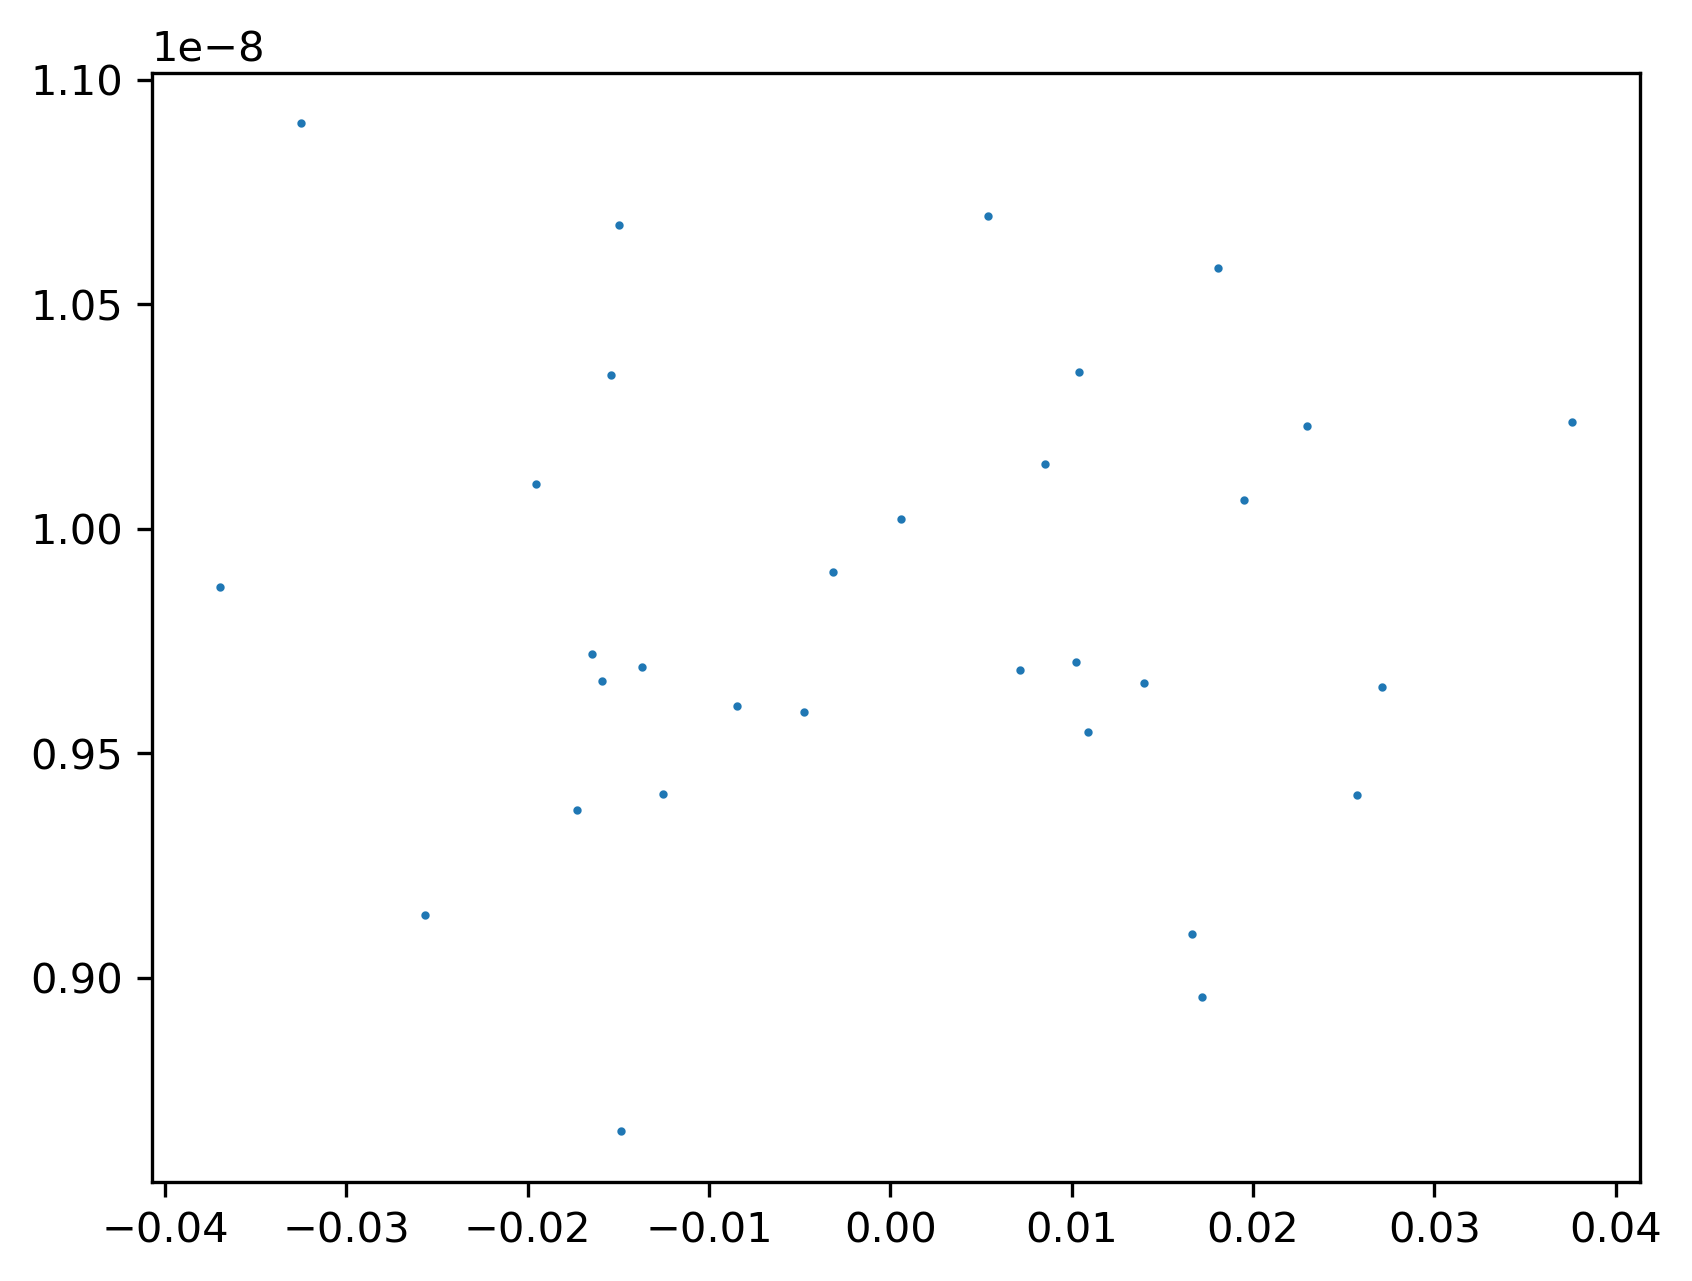

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt, matplotlib; matplotlib.rcParams['figure.dpi']=300
Z_pca=PCA(n_components=2,random_state=42).fit_transform(Z)
plt.scatter(Z_pca[:,0],Z_pca[:,1],s=1)
plt.show()

In [25]:
# Use the following if you would like to save the model
PATH_TO_SAVE = 'dnam_vae_example'
torch.save(vae_model, PATH_TO_SAVE)

In [26]:
# To load up the model again in the future
MODEL_PATH = 'dnam_vae_example'
model_loaded = torch.load(MODEL_PATH)